<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

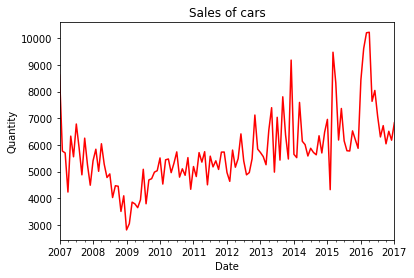

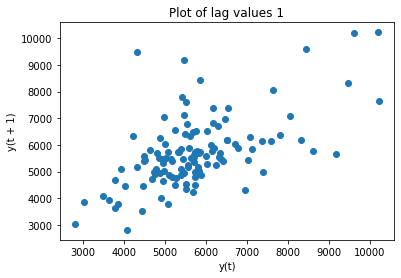

ModuleNotFoundError: No module named 'statsmodels'

In [2]:
# This kernel allows for data exploration & diagnostics before fitting models. Two forecasting techniques are explored viz... LSTM - RNN & SARIMA. The hyperparameters are auto-tuned using gridsearchCV in case of LSTM & for loops in case of SARIMA. There is further scope to improve the forecast by removing/treating outliers.

# load and plot dataset
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from importlib import reload
from numpy import array
import numpy

import sys
from imp import reload
if sys.version[0] == '2':
    reload(sys)
    sys.setdefaultencoding("utf-8")

#Importing data
df = read_csv('./input/norway_new_car_sales_by_model.csv',encoding='cp1252')

#Printing head
df.head()
df.tail()

# Summarizing the dataset
#How many rows the dataset have
df['Quantity'].count()

from pandas import Series, DataFrame
import pandas as pd
import matplotlib.pyplot as plt 

df['Date'] = pd.to_datetime(df.assign(Day=1).loc[:, ['Year','Month','Day']])
#retain only date & quantity
df = df[['Date','Quantity']]
df = df.groupby(['Date']).sum()
df.head()

# Plotting data
df['Quantity'].plot(color='red')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Sales of cars')
plt.show()

# The plot created from running the below shows a relatively strong positive correlation between observations and their lag1 values
from pandas.plotting import lag_plot
lag_plot(df)
plt.title('Plot of lag values 1')
pyplot.show()


# Autocorrelation plot for the time series
from pandas.plotting import autocorrelation_plot
# from pandas.core import datetools
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df, lags=36)
pyplot.show

# Partial Autocorrelation plot for the time series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df, lags=50)
pyplot.show()

In [ ]:
# Functions that will be used during the model build phase
# This segment does not produce any output

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from pandas import Series
from pandas import concat

# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(len(n_in), 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, len(n_out)):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#data = df
#series_to_supervised(df, n_in=3, n_out=5, dropnan=True)

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    # transform data to be stationary
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    # rescale values to -1, 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    # transform into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    # split into train and test sets
    train, test = supervised_values[0:-len(n_test)], supervised_values[-len(n_test):]
    return scaler, train, test

# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return forecast
 
# make all forecasts & append them
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
 
    
# invert differenced forecast
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
 
# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
 
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))

       
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    pyplot.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        pyplot.plot(xaxis, yaxis, color='red')
    # show the plot
    pyplot.show()

In [ ]:
# Automated tuning of hyperparameters using Grid Search. 

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# fix random seed for reproducibility
seed = 5
numpy.random.seed(seed)

# fit an LSTM network to training data
def fit_lstm_tuning(n_test = 28, n_lag = 1, n_batch = 1, n_neurons = 1, activation = 'sigmoid', optimizer = 'adam'):
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, 1, n_lag), activation = activation, stateful=True))
    model.add(Dense(y.shape[1]))
    #model.add(Activation('sigmoid'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
    return model

# define the grid search parameters
n_lag = [1]
#n_lag = [*map(int, n_lag)]
n_seq = [1]
#n_epochs = [1500, 2000, 2500, 3000]
n_batch = [1]
n_neurons = [1,2,3]
activation = ['softmax', 'relu', 'tanh', 'sigmoid']
optimizer = ['SGD', 'RMSprop','Adam']
# configure
series = df
n_test = [26]

#series = series.values.tolist()
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)
X_input, y_dependent = train[:, 0:len(n_lag)], train[:, len(n_lag):]
X, y = X_input, y_dependent
X = X.reshape(X.shape[0], 1, X.shape[1])

# create model
model = KerasClassifier(build_fn=fit_lstm_tuning, epochs = 1500, batch_size = 1, verbose=0)

param_grid = dict(n_batch = n_batch, n_neurons = n_neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# ARIMA model for time series forecasting. This section provides a comparison of forecasts obtained using ARIMA.

import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

#Visualizing Time-series Data
df.plot(figsize=(15, 6))
plt.show()

#time-series seasonal decomposition
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

decomposition = sm.tsa.seasonal_decompose(df, model='additive')
fig = decomposition.plot()
plt.show()

# Parameter Selection for the ARIMA Time Series Model

#Define the p, d and q parameters to take any value between 0 and 2
p = range(0, 3)
d = range(0, 3)
q = range(0, 1)

#Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

#Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

warnings.filterwarnings("ignore") # specify to ignore warning messages

# All combinations of parameters are used & best set of parameters with Minimum AIC is selected
AIC_list = pd.DataFrame({}, columns=['param','param_seasonal','AIC'])
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            temp = pd.DataFrame([[ param ,  param_seasonal , results.aic ]], columns=['param','param_seasonal','AIC'])
            AIC_list = AIC_list.append( temp, ignore_index=True)  # DataFrame append 는 일반 list append 와 다르게 이렇게 지정해주어야한다.
            del temp

        except:
            continue


m = np.nanmin(AIC_list['AIC'].values) # Find minimum value in AIC
l = AIC_list['AIC'].tolist().index(m) # Find index number for lowest AIC
Min_AIC_list = AIC_list.iloc[l,:]

# Fitting ARIMA model wtih best parameters obtained using Minimum AIC
mod = sm.tsa.statespace.SARIMAX(df,
                                order=Min_AIC_list['param'],
                                seasonal_order=Min_AIC_list['param_seasonal'],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

print("### Min_AIC_list ### \n{}".format(Min_AIC_list))

print(results.summary().tables[1])

results.plot_diagnostics(figsize=(15, 12))
plt.show()

# Validating Forecasts
pred_dynamic = results.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = df['2007':].plot(label='observed')
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2016-01-01'), df.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Car Sales')

plt.legend()
plt.show()

#Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = df['2016-01-01':]

#Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))            
            
         
# Producing and Visualizing Forecasts
#Get forecast 'x' steps ahead in future
pred_uc = results.get_forecast(steps=24)

#Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

#plot the time series and forecasts of its future values
ax = df.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Car Sales')

plt.legend()
plt.show()

# I began with order of moving average (value of q) ranging from 1 to 3. However, any moving average order is causing the accuracy to dip. I removed the order of moving average (q) as the p-value was not significant & was also impacting other order of AR (p-value to be insignificant for oder of AR). This forecast is after removing order of moving average. It can be noticed that there is an outlier (Feb 2015) which is being captured in the model & impacting the forecast. As a next step this outlier can be treated & forecast exercise run again.